In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=mnist_transform)
mnist_test  = datasets.MNIST(root="data", train=False, download=True, transform=mnist_transform)

train_size = int(0.9 * len(mnist_train))
val_size   = len(mnist_train) - train_size

mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(mnist_val, batch_size=64)
test_loader  = DataLoader(mnist_test, batch_size=64)


100%|██████████| 9.91M/9.91M [00:00<00:00, 131MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 88.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.44MB/s]


In [4]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [5]:
model = MNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [6]:
def train_eval(train_loader, val_loader, epochs=10):
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step()
        print(f"Epoch {epoch+1}: Train {train_acc:.3f}, Val {val_acc:.3f}")

    return train_accs, val_accs


In [7]:
mnist_train_acc, mnist_val_acc = train_eval(train_loader, val_loader)


Epoch 1: Train 0.934, Val 0.982
Epoch 2: Train 0.976, Val 0.988
Epoch 3: Train 0.982, Val 0.989
Epoch 4: Train 0.984, Val 0.990
Epoch 5: Train 0.986, Val 0.990
Epoch 6: Train 0.991, Val 0.993
Epoch 7: Train 0.993, Val 0.993
Epoch 8: Train 0.993, Val 0.993
Epoch 9: Train 0.994, Val 0.992
Epoch 10: Train 0.995, Val 0.992


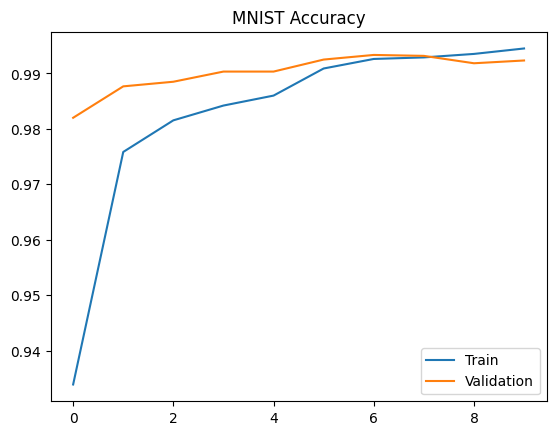

In [8]:
plt.plot(mnist_train_acc, label="Train")
plt.plot(mnist_val_acc, label="Validation")
plt.title("MNIST Accuracy")
plt.legend()
plt.show()


In [9]:
cifar_train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

cifar_test_tf = transforms.Compose([
    transforms.ToTensor()
])


In [10]:
cifar10 = datasets.CIFAR10(root="data", train=True, download=True, transform=cifar_train_tf)
cifar100 = datasets.CIFAR100(root="data", train=True, download=True, transform=cifar_train_tf)


100%|██████████| 170M/170M [00:01<00:00, 107MB/s]
100%|██████████| 169M/169M [00:01<00:00, 106MB/s]


In [11]:
def split_dataset(dataset):
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])


In [12]:
c10_train, c10_val = split_dataset(cifar10)
c10_train_loader = DataLoader(c10_train, batch_size=128, shuffle=True)
c10_val_loader   = DataLoader(c10_val, batch_size=128)


In [13]:
class CIFARCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [21]:
model = CIFARCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)


In [22]:
def train_eval(train_loader, val_loader, epochs=5):
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_acc)
        print(f"Epoch {epoch+1}: Train {train_acc:.3f}, Val {val_acc:.3f}")

    return train_accs, val_accs

In [23]:
_train_acc, _val_acc = train_eval(c10_train_loader, c10_val_loader)


Epoch 1: Train 0.404, Val 0.510
Epoch 2: Train 0.508, Val 0.546
Epoch 3: Train 0.546, Val 0.609
Epoch 4: Train 0.573, Val 0.626
Epoch 5: Train 0.594, Val 0.652


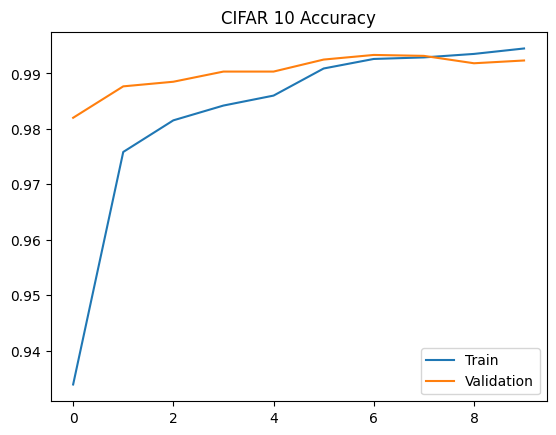

In [24]:
plt.plot(mnist_train_acc, label="Train")
plt.plot(mnist_val_acc, label="Validation")
plt.title("CIFAR 10 Accuracy")
plt.legend()
plt.show()
